## Memo_re_0825_8

### to version = "memo_0825_8"

In [34]:
### configuration
to_save_candidate=True
next_round = 1187
to_version="memo_0825_8"

title = "Metrics"
row_length = 400
new_to_old = True
show_mark_down = True
markdown_table_limit_length = 5
next_nums = [17, 6, 32, 28, 29, 22]
db_path = '../db/metrics.db'

In [35]:
## this code was run.
#!pip install keras-tuner
# import numpy as np
# import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
from IPython.display import Markdown
import sys

sys.path.append("/home/jovyan/work/LSTM_Analyze/foresttrans")

from lib.analy_util import ( draw_markdown,
                             draw_graph,
                             draw_scatter,
                             get_pre_bef,
                             draw_average,
                             get_frequency,
                             get_information,
                             analyze_v1,
                             data_prepare,
                             search_model,
                             get_information_v2,
                             get_extdatas,
                             )
print(f'define this code. [{datetime.now()}]')


define this code. [2025-08-29 14:11:15.960161]


In [36]:
"""
매트릭 데이터 초기화
"""

metrics = [[], [], [], [], [], []]
sel_query = 'select n1, n2, n3, n4, n5, n6 from results_order order by round asc;'
rows = !echo "{sel_query}"|sqlite3 {db_path}
for row in rows:
    cols = [int(i) for i in row.split('|')]
    for i in range(len(cols)):
        metrics[i].append(cols[i])
print(f'define this code. [{datetime.now()}]')


define this code. [2025-08-29 14:11:16.217202]


In [37]:
def draw_frequency(row_nums=[], next_nums=[0]):
    """ draw_frequency """
    sel_query_0 = 'select '
    sel_query_2 = ' from results_order order by round asc;'
    sel_query_1 = []
    if len(row_nums) != len(next_nums):
        print("error : row_nums와 next_nums의 크기가 다릅니다.")
        return 
    for row_num in row_nums:
        sel_query_1.append(f'n{row_num}')
    sel_query = sel_query_0 + ", ".join(sel_query_1) + sel_query_2
    rows = !echo "{sel_query}"|sqlite3 {db_path}
    latest_nums = rows[-1]
    results = []
    for i in range(len(row_nums)):
        results.append([])
    for row in rows:
        cols = row.split("|")
        for i in range(len(cols)):
            results[i].append(int(cols[i]))
        # results.append([int(i) for i in row[0]])
    for result in results:
        print(result)
    for i in range(len(results)):
        results[i].append(next_nums[i])
        
    results += next_nums
    ext_datas = []
    show_cols = []
    
    for i in range(len(row_nums)):
        show_cols.append(i)
    
    print(f'show_cols = {show_cols}')
    
    show_label = True
    
    legend_right_pos = False
    
    show_cnt = len(results[0])
    
    start_pos = 0
    vline_poses = []

    for i in range(1, show_cnt + 1):
        vline_poses.append((i, 0, 45))
    draw_scatter(Y=results,
                 title=f"{row_nums}\'s Nums : {latest_nums} / {next_nums}",
                 show_line=True,
                 show_dot=True,
                 show_cols=show_cols,
                 ext_datas=ext_datas,
                 show_label=show_label,
                 legend_right_pos=legend_right_pos,
                 helper_line_nums=[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                 marker_size=3,
                 fig_size=(12,6),
                 save_fig=False,
                 show_time=False,
                 vline_poses=vline_poses
                )
    print(f'execute this code. [{datetime.now()}]')


def draw_frequency_v2(row_nums=[], metrics=[], next_nums=[0], data_length=-1):
    """ draw_frequency """
    if len(row_nums) != len(next_nums):
        print(f'Error : data size is not eauql. [{len(row_nums)}, {len(metrics)}, {len(next_nums)}]')
        return
    
    latest_nums = []
    y_data = [[], [], [], [], [], []]
    show_cols = []
    ext_datas = []
    show_label = True
    legend_right_pos = False
    show_cnt = len(metrics[0])
    start_pos = 0
    vline_poses = []

    if data_length == -1 or data_length > len(metrics[0]):
        data_start_pos = 0
        data_length = len(metrics[0])
    else:
        data_start_pos = len(metrics[0]) - data_length
    show_cnt = data_length

    for i in range(len(row_nums)):
        y_data[i] = metrics[row_nums[i]-1][data_start_pos:] + [next_nums[i]]
        latest_nums.append(metrics[row_nums[i]-1][-1])
    for i in range(len(row_nums)):
        show_cols.append(i)
    for i in range(1, show_cnt + 1):
        vline_poses.append((i, 0, 45))

    draw_scatter(Y=y_data,
                 title=f"{row_nums}\'s Nums : {latest_nums} / {next_nums}",
                 show_line=True,
                 show_dot=True,
                 show_cols=show_cols,
                 ext_datas=[],
                 show_label=show_label,
                 legend_right_pos=legend_right_pos,
                 helper_line_nums=[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45],
                 marker_size=3,
                 fig_size=(12,6),
                 save_fig=False,
                 show_time=False,
                 vline_poses=vline_poses
                )
    print(f'execute this code. [{datetime.now()}]')


def get_likey(like_query, next_round):
    """
    get_likey
    기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다. 
    """
    
    rows = !echo "{like_query}" | sqlite3 {db_path}
    cur_next_round = next_round
    print(f" Round | Metrics{' ' * 16}| Sum | Depth \n{'-'*46}")
    if len(rows) > 0:
        for row in rows:
            cols = row.split("|")
            nums = [int(i) for i in cols[2].split(',')]
            nums_str = [f"{int(i): >2}" for i in nums]
            round_diff = 0
            cur_round = int(cols[1])        
            if next_round > 0:
                round_diff = cur_next_round - cur_round
            cur_next_round = cur_round
            print(f"{cur_round: >6} | {', '.join(nums_str)} | {sum(nums): >3} | {round_diff: >5}")
    else:
        print('data is empty.')


def get_candidated(version: str) -> []:
    """ get_candidated """
    sel_query = f'select n0, n1, n2, n3, n4, n5 from candidated where version=\\"{version}\\";'
    rows = !echo "{sel_query}" | sqlite3 {db_path}
    if len(rows) > 0:
        cols = rows[0].split("|")
        if len(cols) == 6:
            return [int(i) for i  in cols]
    return []


def update_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """ update_candidated """
    update_query = f'update candidated set n0={n1}, n1={n2}, n2={n3}, n3={n4}, n4={n5}, n5={n6} where version=\\"{version}\\";'
    !echo "{update_query}" | sqlite3 {db_path}


def insert_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """insert_candidated"""
    insert_query = f'insert into candidated(version, n0, n1, n2, n3, n4, n5) values( \\"{version}\\", {n1}, {n2}, {n3}, {n4}, {n5}, {n6});'
    !echo "{insert_query}" | sqlite3 {db_path}


def checknupdate_candidated(version: str, n1: int, n2: int, n3: int, n4: int, n5: int, n6: int):
    """checknupdate_candidated"""
    results = get_candidated(version=version)
    if len(results) == 0:
        insert_candidated(version, n1, n2, n3, n4, n5, n6)
    else:
        cur = [n1, n2, n3, n4, n5, n6]
        equal = True
        for i in range(len(results)):
            if results[i] != cur[i]:
                equal = False
                break
        if equal == False:
            update_candidated(version, n1, n2, n3, n4, n5, n6)


def get_last(round: int):
    """ get_last """
    sel_query = f'select n1, n2, n3, n4, n5, n6, bonus from results_order where round={round};'
    rows = !echo "{sel_query}" | sqlite3 {db_path}
    if len(rows) > 0:
        cols = rows[0].split('|')
        return (int(i) for i in cols)
    return ()


def get_level_count(nums:[], level=10):
    """ get_level_count """
    level_dict = {}
    for num in nums:
        level_val = num - (num % level)
        if level_val in level_dict:
            level_dict[level_val] += 1
        else:
            level_dict[level_val] = 1
    sorted_dict = dict(sorted(level_dict.items()))
    return sorted_dict


def get_frequency(nums: [], d_length: int = 0, is_desc: bool = False):
    """ get_frequency """
    freq_dict = {}
    for num in nums:
        if num in freq_dict:
            freq_dict[num] += 1
        else:
            freq_dict[num] = 1
    sorted_items = sorted(freq_dict.items(), key=lambda item: item[1], reverse=is_desc)
    if is_desc:
        if d_length > 0:
            return sorted_items[0:d_length]
        return sorted_items
    if d_length > 0:
        return sorted_items[-d_length]
    return sorted_items


In [38]:
# 14,16,23,25,31,37
# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
like_query = 'select * from results where metric like \\"3,%,%,24,%,%\\" order by round desc;'
get_likey(like_query, next_round)

 Round | Metrics                | Sum | Depth 
----------------------------------------------
  1179 |  3, 16, 18, 24, 40, 44 | 145 |     8
   784 |  3, 10, 23, 24, 31, 39 | 130 |   395
   710 |  3,  4,  9, 24, 25, 33 |  98 |    74
   702 |  3, 13, 16, 24, 26, 29 | 111 |     8


In [39]:
# 기준이 되는 수에 대한 DB의 기존 데이터를 출력합니다.
likes = [ 'metric like \\"1,%,%,%,%,45\\"',
          # 'metric like \\"2,%,%,%,%,45\\"',
          # 'metric like \\"3,%,%,%,%,45\\"',
          # 'metric like \\"4,%,%,%,%,45\\"',
        ]
likes_str = " or ".join(likes)
order_str = ' order by round desc'
like_query = 'select * from results where ' + likes_str + order_str + ';'
get_likey(like_query, next_round)

 Round | Metrics                | Sum | Depth 
----------------------------------------------
  1119 |  1,  9, 12, 13, 20, 45 | 100 |    68
  1106 |  1,  3,  4, 29, 42, 45 | 124 |    13
  1075 |  1, 23, 24, 35, 44, 45 | 172 |    31
  1003 |  1,  4, 29, 39, 43, 45 | 161 |    72
   943 |  1,  8, 13, 36, 44, 45 | 147 |    60
   885 |  1,  3, 24, 27, 39, 45 | 139 |    58
   845 |  1, 16, 29, 33, 40, 45 | 164 |    40
   800 |  1,  4, 10, 12, 28, 45 | 100 |    45
   705 |  1,  6, 17, 22, 28, 45 | 119 |    95
   676 |  1,  8, 17, 34, 39, 45 | 144 |    29
   675 |  1,  8, 11, 15, 18, 45 |  98 |     1


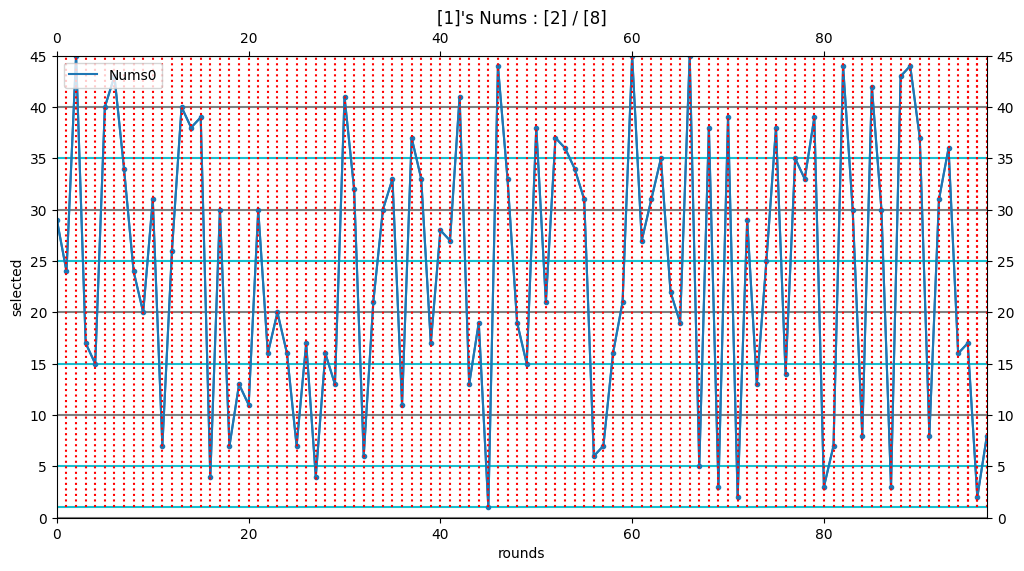

execute this code. [2025-08-29 14:11:17.228254]
history [29, 24, 45, 17, 15, 40, 43, 34, 24, 20, 31, 7, 26, 40, 38, 39, 4, 30, 7, 13, 11, 30, 16, 20, 16, 7, 17, 4, 16, 13, 41, 32, 6, 21, 30, 33, 11, 37, 33, 17, 28, 27, 41, 13, 19, 1, 44, 33, 19, 15, 38, 21, 37, 36, 34, 31, 6, 7, 16, 21, 45, 27, 31, 35, 22, 19, 45, 5, 38, 3, 39, 2, 29, 13, 25, 38, 14, 35, 33, 39, 3, 7, 44, 30, 8, 42, 30, 3, 43, 44, 37, 8, 31, 36, 16, 17, 2]
10단위별 데이터 분포 {0: 18, 10: 21, 20: 15, 30: 30, 40: 13}
5단위별 데이터 분포 {0: 8, 5: 10, 10: 7, 15: 14, 20: 8, 25: 7, 30: 16, 35: 14, 40: 10, 45: 3}
자주 나오는 데이터 [(7, 5), (30, 5), (16, 5), (17, 4), (31, 4), (38, 4), (13, 4), (33, 4), (45, 3), (39, 3), (21, 3), (37, 3), (19, 3), (44, 3), (3, 3), (29, 2), (24, 2), (15, 2), (40, 2), (43, 2), (34, 2), (20, 2), (4, 2), (11, 2), (41, 2), (6, 2), (27, 2), (36, 2), (35, 2), (2, 2), (8, 2), (26, 1), (32, 1), (28, 1), (1, 1), (22, 1), (5, 1), (25, 1), (14, 1), (42, 1)]


In [40]:
row_nums = [1]
next_nums[row_nums[0]-1] = 8
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=[next_nums[row_nums[0]-1]], data_length=-1)
print('history', metrics[row_nums[0]-1])
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

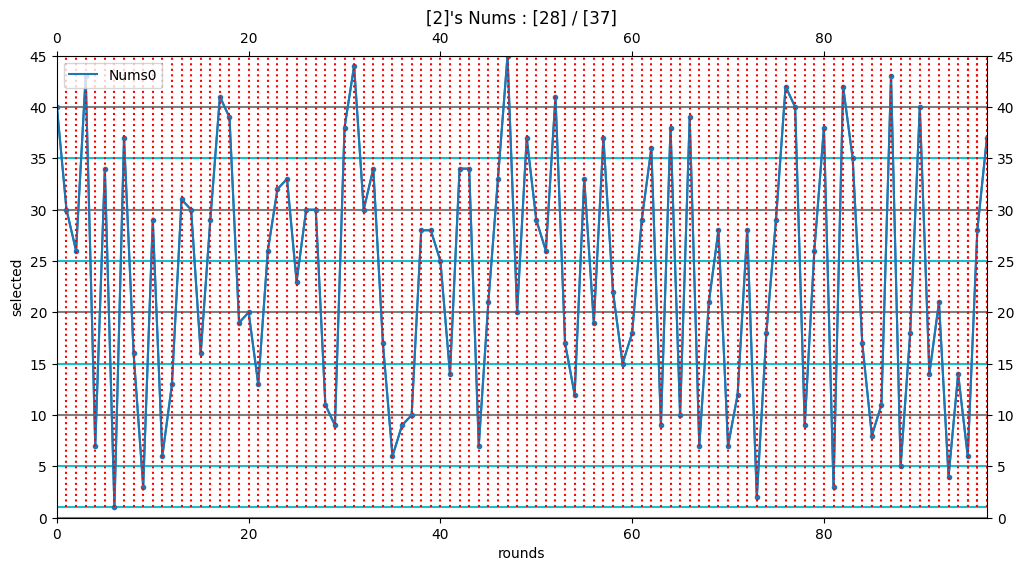

execute this code. [2025-08-29 14:11:17.438411]
10단위별 데이터 분포 {0: 18, 10: 22, 20: 22, 30: 24, 40: 11}
5단위별 데이터 분포 {0: 5, 5: 13, 10: 11, 15: 11, 20: 7, 25: 15, 30: 14, 35: 10, 40: 10, 45: 1}
자주 나오는 데이터 [(30, 5), (29, 5), (28, 5), (26, 4), (7, 4), (34, 4), (9, 4), (40, 3), (37, 3), (6, 3), (33, 3), (38, 3), (17, 3), (14, 3), (21, 3), (18, 3), (43, 2), (16, 2), (3, 2), (13, 2), (41, 2), (39, 2), (19, 2), (20, 2), (11, 2), (10, 2), (12, 2), (42, 2), (1, 1), (31, 1), (32, 1), (23, 1), (44, 1), (25, 1), (45, 1), (22, 1), (15, 1), (36, 1), (2, 1), (35, 1), (8, 1), (5, 1), (4, 1)]


In [41]:
row_nums = [2]
next_nums[row_nums[0]-1] = 37
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=[next_nums[row_nums[0]-1]])
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

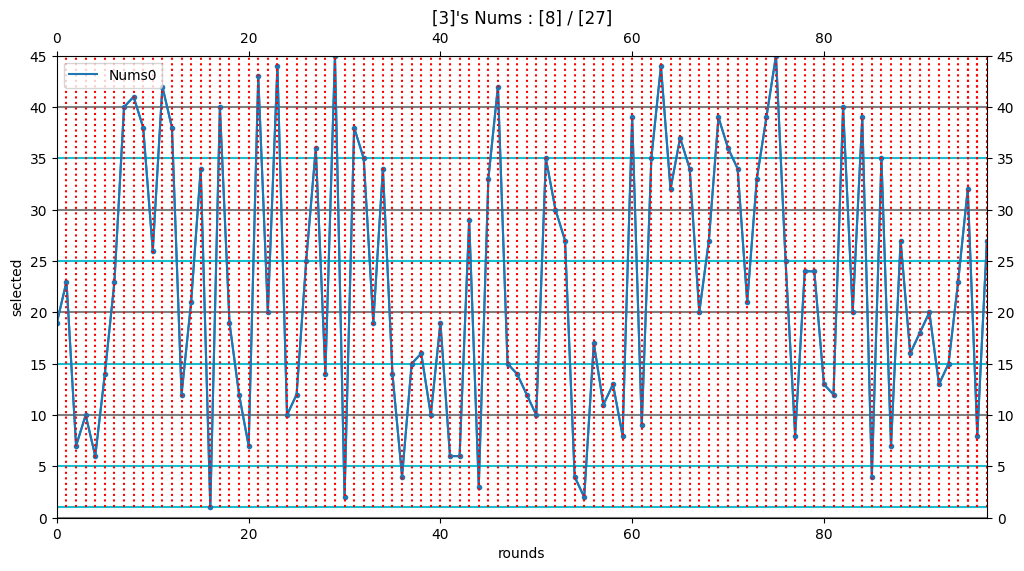

execute this code. [2025-08-29 14:11:17.703413]
history [19, 23, 7, 10, 6, 14, 23, 40, 41, 38, 26, 42, 38, 12, 21, 34, 1, 40, 19, 12, 7, 43, 20, 44, 10, 12, 25, 36, 14, 45, 2, 38, 35, 19, 34, 14, 4, 15, 16, 10, 19, 6, 6, 29, 3, 33, 42, 15, 14, 12, 10, 35, 30, 27, 4, 2, 17, 11, 13, 8, 39, 9, 35, 44, 32, 37, 34, 20, 27, 39, 36, 34, 21, 33, 39, 45, 25, 8, 24, 24, 13, 12, 40, 20, 39, 4, 35, 7, 27, 16, 18, 20, 13, 15, 23, 32, 8]
10단위별 데이터 분포 {0: 17, 10: 28, 20: 18, 30: 23, 40: 11}
5단위별 데이터 분포 {0: 7, 5: 10, 10: 17, 15: 11, 20: 11, 25: 7, 30: 9, 35: 14, 40: 9, 45: 2}
자주 나오는 데이터 [(12, 5), (19, 4), (10, 4), (14, 4), (34, 4), (20, 4), (35, 4), (39, 4), (23, 3), (7, 3), (6, 3), (40, 3), (38, 3), (4, 3), (15, 3), (27, 3), (13, 3), (8, 3), (42, 2), (21, 2), (44, 2), (25, 2), (36, 2), (45, 2), (2, 2), (16, 2), (33, 2), (32, 2), (24, 2), (41, 1), (26, 1), (1, 1), (43, 1), (29, 1), (3, 1), (30, 1), (17, 1), (11, 1), (9, 1), (37, 1), (18, 1)]


In [42]:
row_nums = [3]
next_nums[row_nums[0]-1] = 27
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=[next_nums[row_nums[0]-1]])
print('history', metrics[row_nums[0]-1])
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

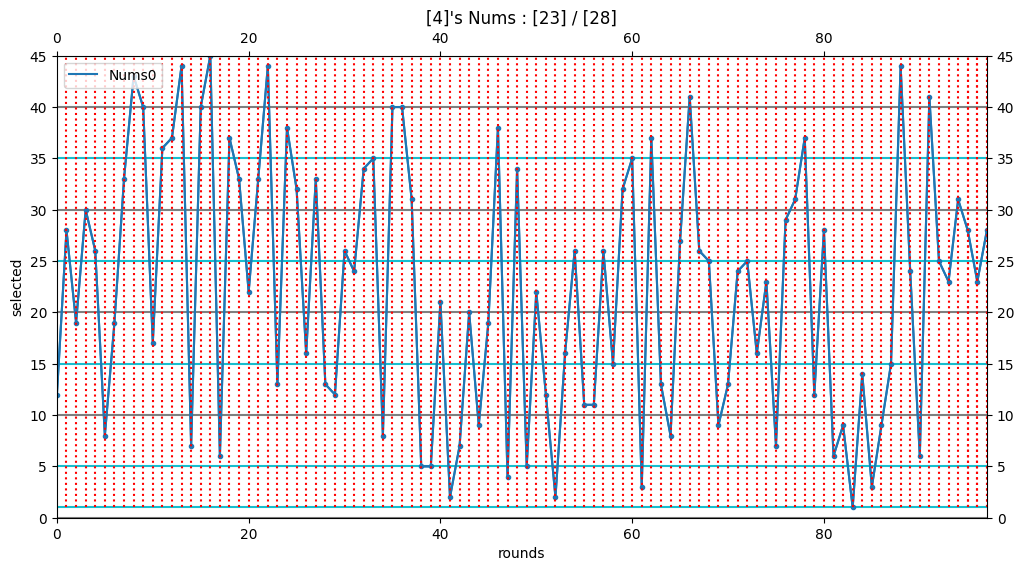

execute this code. [2025-08-29 14:11:18.129234]
10단위별 데이터 분포 {0: 22, 10: 20, 20: 23, 30: 21, 40: 11}
5단위별 데이터 분포 {0: 6, 5: 16, 10: 11, 15: 9, 20: 10, 25: 13, 30: 12, 35: 9, 40: 10, 45: 1}
자주 나오는 데이터 [(26, 5), (12, 4), (33, 4), (40, 4), (37, 4), (13, 4), (9, 4), (28, 3), (19, 3), (8, 3), (44, 3), (7, 3), (6, 3), (16, 3), (24, 3), (31, 3), (5, 3), (25, 3), (23, 3), (22, 2), (38, 2), (32, 2), (34, 2), (35, 2), (2, 2), (11, 2), (15, 2), (3, 2), (41, 2), (30, 1), (43, 1), (17, 1), (36, 1), (45, 1), (21, 1), (20, 1), (4, 1), (27, 1), (29, 1), (1, 1), (14, 1)]


In [43]:
### 네 번쨰 라인 검사
sel_item = 0
if sel_item == 0:
    row_nums = [4]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1]]
if sel_item == 1:
    row_nums = [3, 4]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [4, 5]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [3, 4, 5]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1], next_nums[row_nums[2]-1]]

next_nums[row_nums[cur_col_id]-1] = 33

draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=next_nums_this)
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

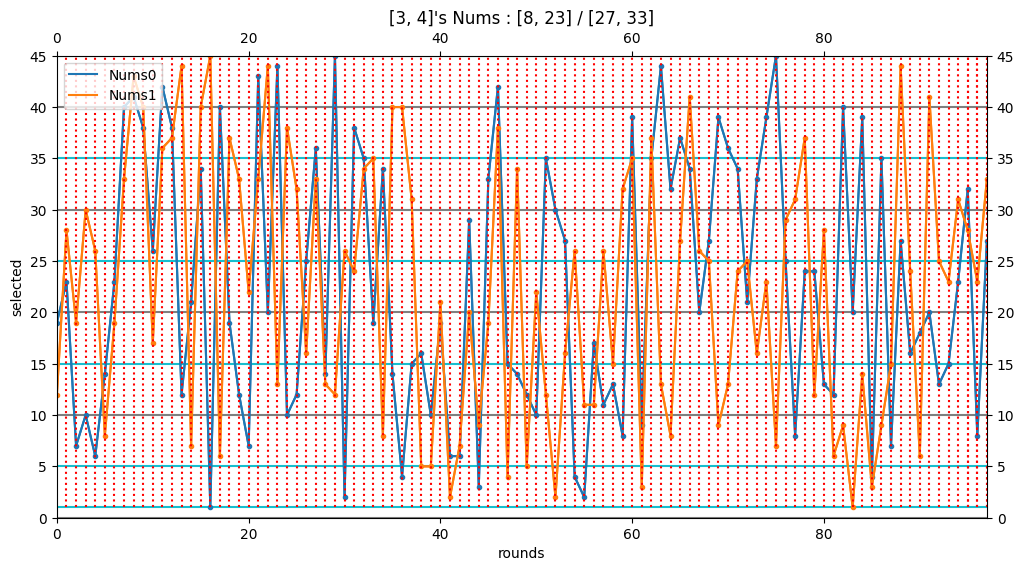

execute this code. [2025-08-29 14:11:18.315028]
10단위별 데이터 분포 {0: 17, 10: 28, 20: 18, 30: 23, 40: 11}
5단위별 데이터 분포 {0: 7, 5: 10, 10: 17, 15: 11, 20: 11, 25: 7, 30: 9, 35: 14, 40: 9, 45: 2}
자주 나오는 데이터 [(12, 5), (19, 4), (10, 4), (14, 4), (34, 4), (20, 4), (35, 4), (39, 4), (23, 3), (7, 3), (6, 3), (40, 3), (38, 3), (4, 3), (15, 3), (27, 3), (13, 3), (8, 3), (42, 2), (21, 2), (44, 2), (25, 2), (36, 2), (45, 2), (2, 2), (16, 2), (33, 2), (32, 2), (24, 2), (41, 1), (26, 1), (1, 1), (43, 1), (29, 1), (3, 1), (30, 1), (17, 1), (11, 1), (9, 1), (37, 1), (18, 1)]


In [44]:
### 네 번쨰 라인 검사
sel_item = 1
if sel_item == 0:
    row_nums = [4]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1]]
if sel_item == 1:
    row_nums = [3, 4]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [4, 5]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [3, 4, 5]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1], next_nums[row_nums[2]-1]]

next_nums[row_nums[cur_col_id]-1] = 33

draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=next_nums_this)
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

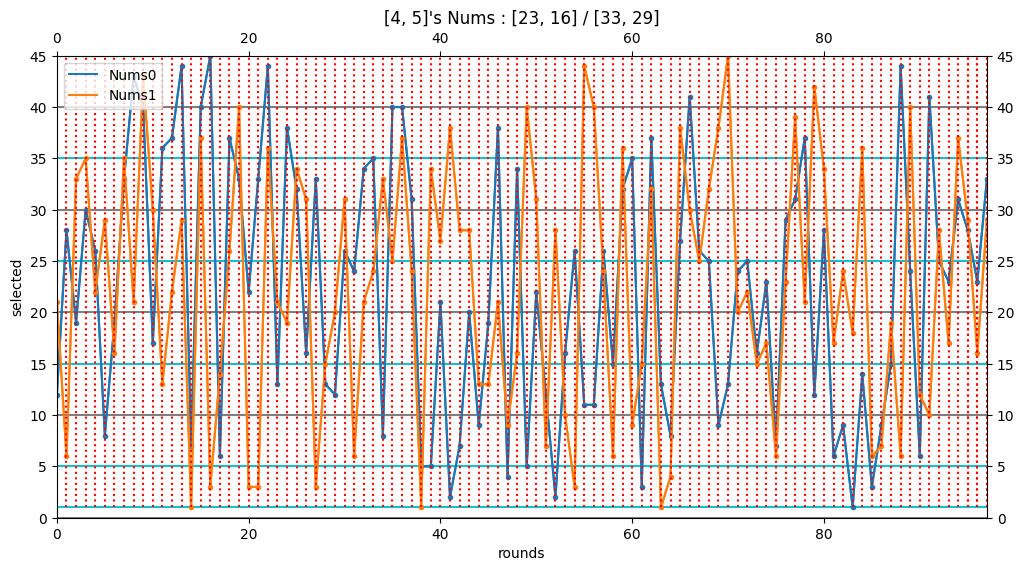

execute this code. [2025-08-29 14:11:18.584450]
10단위별 데이터 분포 {0: 22, 10: 20, 20: 23, 30: 21, 40: 11}
5단위별 데이터 분포 {0: 6, 5: 16, 10: 11, 15: 9, 20: 10, 25: 13, 30: 12, 35: 9, 40: 10, 45: 1}
자주 나오는 데이터 [(26, 5), (12, 4), (33, 4), (40, 4), (37, 4), (13, 4), (9, 4), (28, 3), (19, 3), (8, 3), (44, 3), (7, 3), (6, 3), (16, 3), (24, 3), (31, 3), (5, 3), (25, 3), (23, 3), (22, 2), (38, 2), (32, 2), (34, 2), (35, 2), (2, 2), (11, 2), (15, 2), (3, 2), (41, 2), (30, 1), (43, 1), (17, 1), (36, 1), (45, 1), (21, 1), (20, 1), (4, 1), (27, 1), (29, 1), (1, 1), (14, 1)]


In [45]:
### 네 번쨰 라인 검사
sel_item = 2
if sel_item == 0:
    row_nums = [4]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1]]
if sel_item == 1:
    row_nums = [3, 4]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [4, 5]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 3:
    row_nums = [3, 4, 5]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1], next_nums[row_nums[2]-1]]

next_nums[row_nums[cur_col_id]-1] = 33

draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=next_nums_this)
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

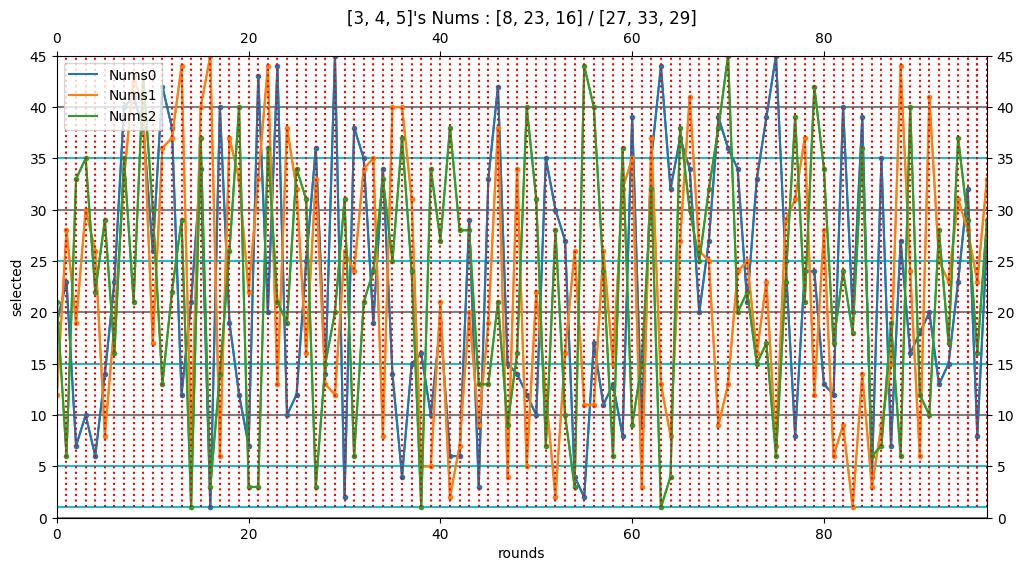

execute this code. [2025-08-29 14:11:18.982370]
10단위별 데이터 분포 {0: 17, 10: 28, 20: 18, 30: 23, 40: 11}
5단위별 데이터 분포 {0: 7, 5: 10, 10: 17, 15: 11, 20: 11, 25: 7, 30: 9, 35: 14, 40: 9, 45: 2}
자주 나오는 데이터 [(12, 5), (19, 4), (10, 4), (14, 4), (34, 4), (20, 4), (35, 4), (39, 4), (23, 3), (7, 3), (6, 3), (40, 3), (38, 3), (4, 3), (15, 3), (27, 3), (13, 3), (8, 3), (42, 2), (21, 2), (44, 2), (25, 2), (36, 2), (45, 2), (2, 2), (16, 2), (33, 2), (32, 2), (24, 2), (41, 1), (26, 1), (1, 1), (43, 1), (29, 1), (3, 1), (30, 1), (17, 1), (11, 1), (9, 1), (37, 1), (18, 1)]


In [46]:
### 네 번쨰 라인 검사
sel_item = 3
if sel_item == 0:
    row_nums = [4]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1]]
if sel_item == 1:
    row_nums = [3, 4]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 2:
    row_nums = [4, 5]
    cur_col_id = 0
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1]]
if sel_item == 3:
    row_nums = [3, 4, 5]
    cur_col_id = 1
    next_nums_this = [next_nums[row_nums[0]-1], next_nums[row_nums[1]-1], next_nums[row_nums[2]-1]]

next_nums[row_nums[cur_col_id]-1] = 33

draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=next_nums_this)
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

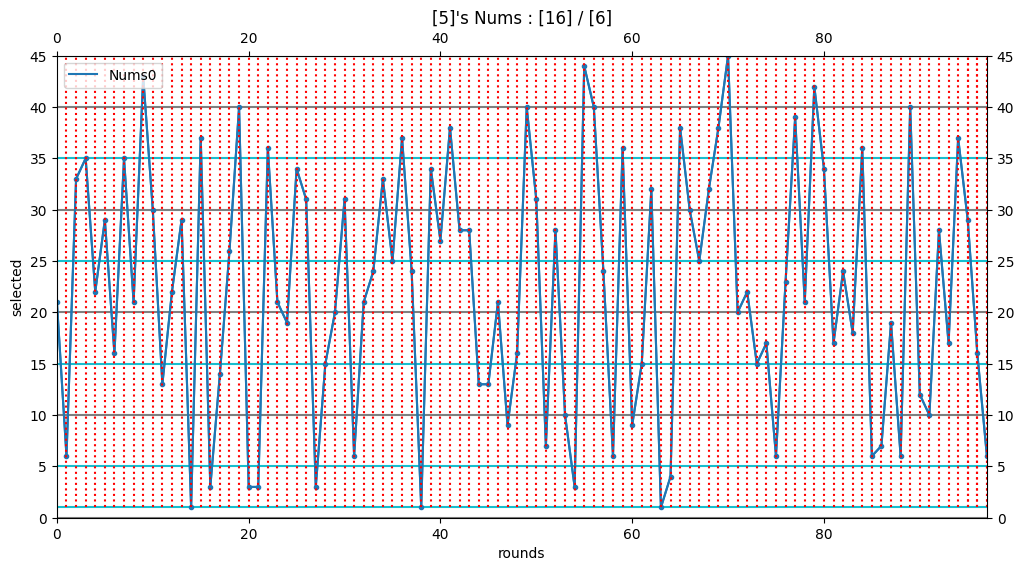

execute this code. [2025-08-29 14:11:19.376476]
10단위별 데이터 분포 {0: 19, 10: 19, 20: 27, 30: 24, 40: 8}
5단위별 데이터 분포 {0: 9, 5: 10, 10: 7, 15: 12, 20: 16, 25: 11, 30: 12, 35: 12, 40: 7, 45: 1}
자주 나오는 데이터 [(21, 6), (6, 6), (3, 5), (40, 4), (24, 4), (28, 4), (22, 3), (29, 3), (16, 3), (13, 3), (1, 3), (37, 3), (36, 3), (34, 3), (31, 3), (15, 3), (38, 3), (17, 3), (33, 2), (35, 2), (30, 2), (19, 2), (20, 2), (25, 2), (9, 2), (7, 2), (10, 2), (32, 2), (43, 1), (14, 1), (26, 1), (27, 1), (44, 1), (4, 1), (45, 1), (23, 1), (39, 1), (42, 1), (18, 1), (12, 1)]


In [47]:
row_nums = [5]
next_nums[row_nums[0]-1] = 6
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=[next_nums[row_nums[0]-1]])
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

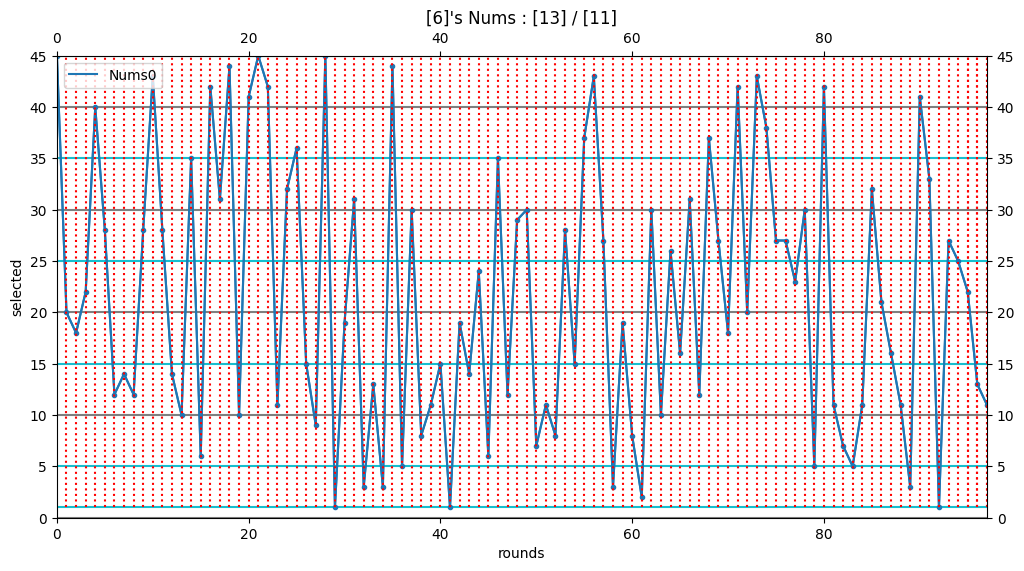

execute this code. [2025-08-29 14:11:20.154905]
10단위별 데이터 분포 {0: 19, 10: 28, 20: 19, 30: 16, 40: 15}
5단위별 데이터 분포 {0: 8, 5: 11, 10: 18, 15: 10, 20: 7, 25: 12, 30: 10, 35: 6, 40: 12, 45: 3}
자주 나오는 데이터 [(11, 6), (27, 5), (28, 4), (12, 4), (42, 4), (3, 4), (30, 4), (45, 3), (14, 3), (43, 3), (10, 3), (31, 3), (15, 3), (1, 3), (19, 3), (5, 3), (8, 3), (20, 2), (18, 2), (22, 2), (35, 2), (6, 2), (44, 2), (41, 2), (32, 2), (13, 2), (7, 2), (37, 2), (16, 2), (40, 1), (36, 1), (9, 1), (24, 1), (29, 1), (2, 1), (26, 1), (38, 1), (23, 1), (21, 1), (33, 1), (25, 1)]


In [48]:
row_nums = [6]
next_nums[row_nums[0]-1] = 11
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=[next_nums[row_nums[0]-1]])
print("10단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=10))
print("5단위별 데이터 분포", get_level_count(metrics[row_nums[0]-1], level=5))
print("자주 나오는 데이터", get_frequency(nums=metrics[row_nums[0]-1], is_desc=True))

#메모
# 13보다 크며, 22보다 크거나 작아야 한다.

In [49]:
next_nums

[8, 37, 27, 33, 6, 11]

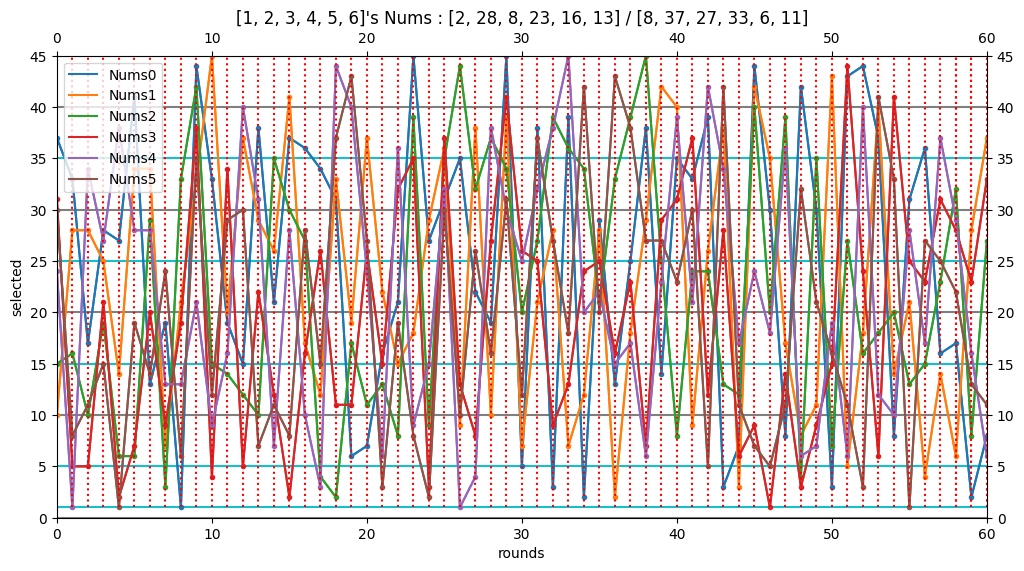

execute this code. [2025-08-29 14:11:21.835981]


In [50]:
row_nums = [1, 2, 3, 4, 5, 6]
draw_frequency_v2(row_nums=row_nums, metrics=metrics, next_nums=next_nums, data_length=60)

In [51]:
if to_save_candidate:
    sorted_nums = next_nums.copy()
    sorted_nums.sort()
    print(sorted_nums)
    checknupdate_candidated(version=to_version,
                            n1 = sorted_nums[0],
                            n2 = sorted_nums[1],
                            n3 = sorted_nums[2],
                            n4 = sorted_nums[3],
                            n5 = sorted_nums[4],
                            n6 = sorted_nums[5])
print('execute this code.', datetime.now())

[6, 8, 11, 27, 33, 37]
execute this code. 2025-08-29 14:11:23.037166
